Author: Karatpetch(Kara) Jiwachotkamjon

# Prediction on Highly Imbalanced multiclassification model for High quality new candidate hire with a high chance of completion of 2-year program

We aim to identify and predict the new candidate who has a potential to complete year2 of the program. With this goal, we will cover the candidate beyond the invited interview status, in other words, we will take into account all the applicant data points in order to predict and evaluate the candidate profile. In terms of model, since the outcome will include 3 classes; 0,1,2 or 'Incomplete','In process' and 'Completed', we're dealing with multiclassification model. Moreover, covering the entire data set without any transformation would create a bias in prediction model, so, in this document, we will also cover the handling of highly imbalanced data set as a preparation for predictive model.

In this part, there will be 4 sections to be covered;
1) Data cleaning
2) Imbalanced handling
3) Predictive model
4) Final outcome

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # for plotting graphs
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("master_data_final2.csv")

External data from 3 main areas have been merged to accuratly predict the outcome including Pell grant amount that varies by Pell grant type, Teacher's salary and Forbes school ranking

Previously mentioned external data and transformed variable, including Day_diff_start_submit, career_level_int, UG_school_selectivity_int, Match_Teach,Uni_State, Uni_Match_state,Forbes_ranking, pell_grant_amount, cluster5, cluster definition, Grand_cluster,Teacher_starting_salary_match and Teacher_starting_salary_teach will be included in the data set.

## 1) Data Cleaning

In [6]:
import pandas as pd                                   #For dataframe operations
from sklearn.model_selection import train_test_split  #For generating training and test sets
from xgboost import XGBClassifier                     #For calculating the probs
from sklearn.isotonic import IsotonicRegression       #For calibrating the probs
from matplotlib import pyplot as plt 

In [7]:
df.set_index('user_ID')

,Unnamed: 0,App_submit_year,App_start_date,App_submit_date,Day_diff_start_submit,ComfirmOffer_date,career_level,UG_school_name,UG_school_selectivity,UG_major_byGroup,...,App_start_month,App_submit_month,ComfirmOffer_month,career_level_int,UG_school_selectivity_int,UG_GPA,applicant_cluster,applicant_cluster_def,region_and_cost_cluster,region_and_cost_cluster_def
user_ID,,,,,,,,,,,,,,,,,,,,,
292,0,2018,15/1/2018,15/1/2018,0,NaN,Undergrad,University of Minnesota - Twin Cities,More Selective,Political Science,...,1,1.0,NaN,2,4,3.16,3,Junior to undergrad from more selectivity school,NaN,NaN
351,1,2016,1/12/2015,1/12/2015,0,NaN,Professional,Foreign University,NaN,Biological science,...,1,1.0,NaN,5,1,0.00,2,Professional from least selectivity school,NaN,NaN
389,2,2016,6/11/2015,2/1/2016,57,18/12/2016,Undergrad,other,NaN,Education (elementary),...,6,2.0,12.0,2,1,3.91,0,Junior to undergrad from least selectivity school,2.0,Relatively high cost region
444,3,2018,13/9/2017,13/9/2017,0,NaN,Undergrad,other,More Selective,International Studies/Relations,...,9,9.0,NaN,1,1,3.24,0,Junior to undergrad from least selectivity school,NaN,NaN
444,4,2018,18/4/2017,21/4/2017,3,NaN,Junior,other,More Selective,International Studies/Relations,...,4,4.0,NaN,1,1,3.24,0,Junior to undergrad from least selectivity school,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12167669,250597,2022,2/3/2022,7/3/2022,5,NaN,Grad Student,other,More Selective,History,...,2,7.0,NaN,4,1,2.70,2,Professional from least selectivity school,NaN,NaN
12173636,250598,2022,1/11/2021,29/11/2021,28,NaN,Professional,other,Most Selective,"Law, Government, Social Sci",...,1,11.0,NaN,5,1,3.10,2,Professional from least selectivity school,NaN,NaN
12193281,250599,2022,18/10/2021,18/10/2021,0,NaN,Professional,University of California-Santa Barbara,Most Selective,Sociology,...,10,10.0,NaN,5,5,3.89,1,Professional from more selectivity school,NaN,NaN


In [8]:
df = df.drop(['Unnamed: 0'],axis=1)

In [311]:
#df = df[df['Progress_1_Invite_Intrvw']==True]

In [312]:
dt = df

In [313]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250602 entries, 0 to 250601
Data columns (total 59 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   user_ID                        250602 non-null  int64  
 1   App_submit_year                250602 non-null  int64  
 2   App_start_date                 250602 non-null  object 
 3   App_submit_date                250414 non-null  object 
 4   Day_diff_start_submit          250602 non-null  int64  
 5   ComfirmOffer_date              23602 non-null   object 
 6   career_level                   250602 non-null  object 
 7   UG_school_name                 250602 non-null  object 
 8   UG_school_selectivity          212036 non-null  object 
 9   UG_major_byGroup               250602 non-null  object 
 10  UG_major_bySchool              250602 non-null  object 
 11  UG_major_minor_STEM            250602 non-null  int64  
 12  UG_sports                     

In [314]:
dt['App_start_year'] = pd.DatetimeIndex(dt['App_start_date']).year

In [315]:
dt = dt.drop(['App_start_date','App_submit_date','ComfirmOffer_date','Progress_1_Invite_Intrvw'
              ,'Progress_2_Complete_Intrvw','Progress_3_Accepted_toCorp','Progress_4_Comfirm_Offer','Progress_5_Start_1stDay','region_and_cost_cluster_def',
          'UG_school_name','LIC_served_rating', 'Match_region','Teach_region','Match_state','career_level_int',
         'applicant_cluster_def','ug_school_selectivity_rv','UG_school_selectivity'],axis =1)

In [317]:
dt['career_level'] = dt['career_level'].replace('Undergrad',2).replace('Junior',1).replace('Co-terming Senior',3).replace('Grad Student',4).replace('Professional',5)
dt['App_start_month'] = dt['App_start_month'].replace(np.nan,0)
dt['App_submit_month'] = dt['App_submit_month'].replace(np.nan,0)
dt['App_start_year'] = dt['App_start_year'].replace(np.nan,0)
dt['App_submit_year'] = dt['App_submit_year'].replace(np.nan,0)
dt['ComfirmOffer_month'] = dt['ComfirmOffer_month'].replace(np.nan,0)
dt['cost_of_living_match_region'] = dt['cost_of_living_match_region'].replace(np.nan,0)
dt['cost_of_living_teach_region'] = dt['cost_of_living_teach_region_x'].replace(np.nan,0)
dt['UG_sports'] = dt['UG_sports'].replace(np.nan,0)
dt['UG_GPA'] = dt['UG_GPA'].apply(pd.to_numeric).astype(np.uint8,errors='ignore')
dt['UG_sports'] = dt['UG_sports'].apply(pd.to_numeric).astype(np.uint8,errors='ignore')
dt['LIC_served_self_report'] = dt['LIC_served_self_report'].replace(np.nan,0)
dt['LIC_served_self_report'] = dt['LIC_served_self_report'].apply(pd.to_numeric).astype(np.uint8,errors='ignore')
dt['UG_GPA'] = dt['UG_GPA'].apply(pd.to_numeric).astype(np.uint8,errors='ignore')
dt['Match_Teach'] = dt['Match_Teach'].replace('Yes',1).replace('No',0)
dt['Leadership_role'] = dt['Leadership_role'].replace(np.nan,0)
dt['Leadership_role'] = dt['Leadership_role'].apply(pd.to_numeric).astype(np.uint8,errors='ignore')
dt['UG_PellGrant'] = dt['UG_PellGrant'].replace('1','NO')
dt['UG_PellGrant'] = dt['UG_PellGrant'].replace('MAXIMUM',2).replace('NO',0).replace('PARTIAL',1)
dt['Progress_6_Complete_2yrs'] = dt['Progress_6_Complete_2yrs'].replace('TRUE',2).replace('In process',1).replace('FALSE',0)
dt['Uni_Match_state'] = dt['Uni_Match_state'].replace('Yes',1).replace('No',0)
dt['match_and_offer'] = dt['match_and_offer'].astype('category').cat.codes
dt = dt.drop(['cost_of_living_teach_region_x'],axis=1)

In [319]:
dt['Progress_6_Complete_2yrs'] = dt['Progress_6_Complete_2yrs'].apply(pd.to_numeric)

In [320]:
dt = pd.get_dummies(dt, columns=['UG_major_bySchool','Teach_subject','UG_major_byGroup','Teach_state','Uni_State'])
dt = dt.set_index('user_ID')

In [321]:
dt = dt.dropna(subset = ['Progress_6_Complete_2yrs'])

In [322]:
dt['Progress_6_Complete_2yrs'] = dt['Progress_6_Complete_2yrs'].astype('category').cat.codes

In [323]:
dt = dt.replace(np.nan,0)
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239801 entries, 292 to 12022082
Columns: 191 entries, App_submit_year to Uni_State_WISCONSIN
dtypes: float64(15), int64(14), int8(2), uint8(160)
memory usage: 91.9 MB


In [324]:
dt['Forbes_ranking'] = dt['Forbes_ranking'].astype(np.uint8,errors='ignore')
dt['Day_diff_start_submit'] = dt['Day_diff_start_submit'].astype(np.uint8,errors='ignore')
dt['UG_major_minor_STEM'] = dt['UG_major_minor_STEM'].astype(np.uint8,errors='ignore') 
dt['UG_PellGrant']= dt['UG_PellGrant'].astype(np.uint8,errors='ignore')
dt['Preference_Region_level']=dt['Preference_Region_level'].astype(np.uint8,errors='ignore')
dt['Preference_Region_rank']= dt['Preference_Region_rank'].astype(np.uint8,errors='ignore')
dt['Preferences_Subject_level']=dt['Preferences_Subject_level'].astype(np.uint8,errors='ignore')
dt['UG_school_selectivity_int']=dt['UG_school_selectivity_int'].astype(np.uint8,errors='ignore')
dt['pell_grant_amount']=dt['pell_grant_amount'].astype(np.uint8,errors='ignore')
dt['applicant_cluster']=dt['applicant_cluster'].astype(np.uint8,errors='ignore')
dt['region_and_cost_cluster']=dt['region_and_cost_cluster'].astype(np.uint8,errors='ignore')
dt['count_applicantions']=dt['count_applicantions'].astype(np.uint8,errors='ignore')

## 2)Handling Imbalanced Dataset

Since we need to take into account the whole data set; however, we only aim to focus on the result of Progress 6 for those who is 'in process' and 'complete'. As a result, there's an imbalanced distribution between 3 status including 'Incomplete or o', 'In process or 1' and 'Completed or 2' as shown in the bar plot below.

<AxesSubplot:xlabel='Progress_6_Complete_2yrs', ylabel='count'>

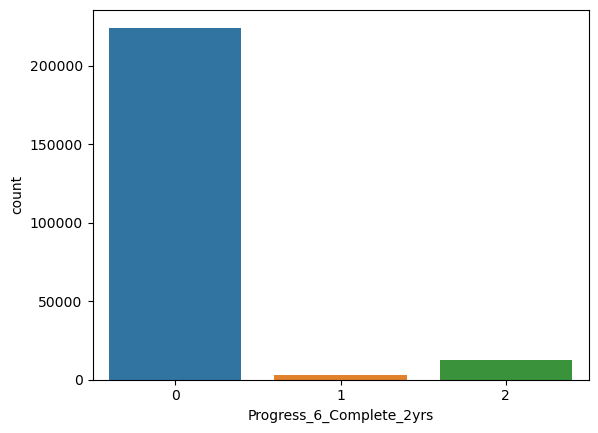

In [325]:
import seaborn as sns
sns.countplot(dt['Progress_6_Complete_2yrs'])

In order to handle this, we chose to implement SMOTE method to handle the imbalanced in the data set before predicting the outcome.

In [326]:
#!pip install imblearn

In [327]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

In [328]:
X = dt.drop('Progress_6_Complete_2yrs',axis=1)
y=dt['Progress_6_Complete_2yrs']

In [329]:
# Define SMOTE-Tomek Links
resample=SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
X, y = resample.fit_resample(X, y)

In [330]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [331]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(n_estimators=200)
etc.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=200)

In [332]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
y_pred = etc.predict(X_test)
print('Accuracy score:',metrics.accuracy_score(y_test, y_pred))

Accuracy score: 0.988989189791597


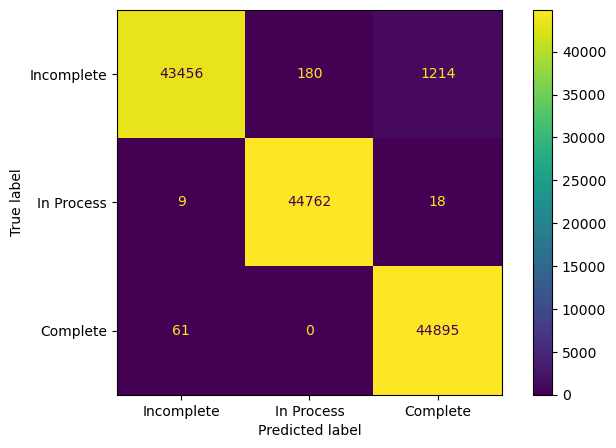

In [333]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(figsize=(8, 5))
cmp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred),
    display_labels=["Incomplete","In Process","Complete"],)
 
cmp.plot(ax=ax)
plt.show();

## Feature importance from Predictive Model

In [334]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    g=sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'],  palette="mako")
    #g.set_xscale("log")
    #ticks = [0.05, 0.1, 0.4]    
    #g.set_xticks(ticks)
    #g.set_xticklabels(ticks)
    #plt.legend([],[], frameon=False)
  
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    #plt.xlabel('FEATURE IMPORTANCE')
    #plt.ylabel('FEATURE NAMES')

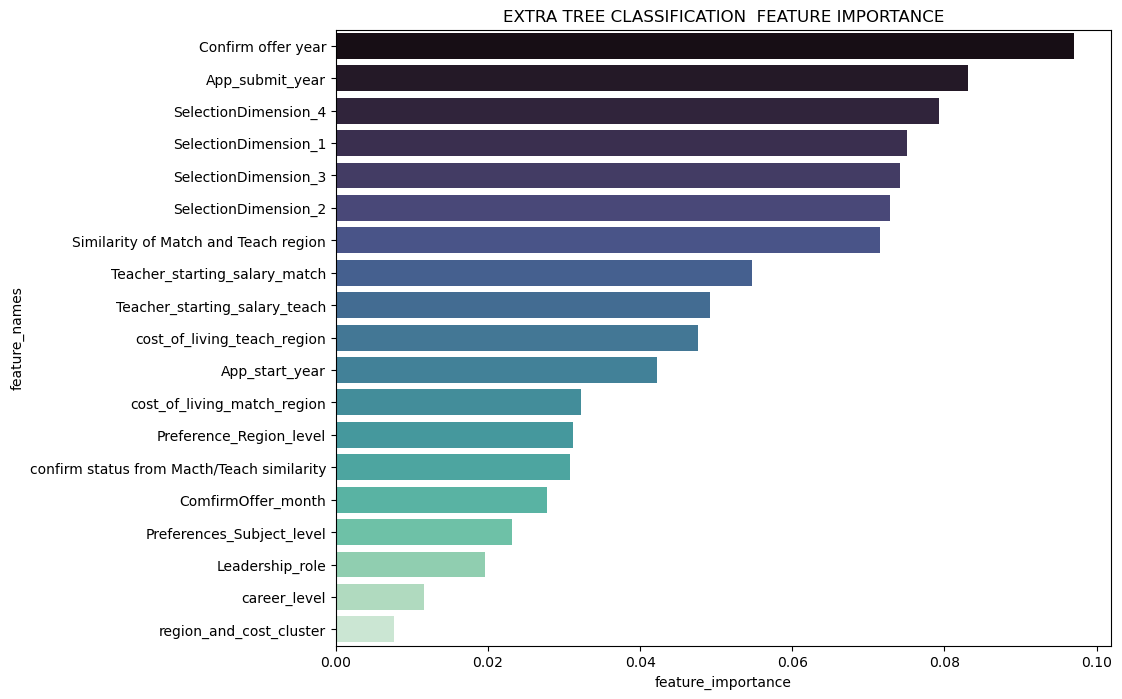

In [335]:
Importance=pd.DataFrame(columns=["feature_importance", "feature_names"])
Importance.feature_importance=list(etc.feature_importances_)
Importance.feature_names=X_train.columns
Importance.feature_names=Importance.feature_names.replace('career_level_int', "career level").replace('cf_year', "Confirm offer year").replace('Match_Teach', "Similarity of Match and Teach region").replace('Uni_Match_state', "Similarity of University and Match state").replace('match_and_offer', "confirm status from Macth/Teach similarity").replace('cluster5',"Applicant clustering")
Importance=Importance.sort_values(by="feature_importance", ascending=False)
Importance=Importance[Importance["feature_importance"]>0.005]
plot_feature_importance(Importance.feature_importance,Importance.feature_names,"EXTRA TREE CLASSIFICATION ")

In [336]:
X_test.head()

,App_submit_year,Day_diff_start_submit,career_level,UG_major_minor_STEM,UG_sports,UG_PellGrant,LIC_served_self_report,Leadership_role,SelectionDimension_1,SelectionDimension_2,...,Uni_State_OTHERS,Uni_State_PENNSYLVANIA,Uni_State_SOUTH CAROLINA,Uni_State_TENNESSEE,Uni_State_TEXAS,Uni_State_UTAH,Uni_State_VIRGINIA,Uni_State_WASHINGTON,Uni_State_WASHINGTON D.C.,Uni_State_WISCONSIN
477530,2016,39,2,0,0,0,0,1,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0
591492,2018,2,1,0,0,0,1,1,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0
418936,2021,0,4,0,0,1,1,1,2.663301,2.762701,...,0,0,0,0,0,0,0,0,0,0
267994,2021,12,4,0,0,1,1,1,2.800000,3.333071,...,0,0,0,0,0,0,0,0,0,0
17066,2017,6,3,0,0,0,0,1,0.000000,0.000000,...,1,0,0,0,0,0,0,0,0,0


In [337]:
a = pd.DataFrame({"Actual": y_test, "Predictions": y_pred})

In [338]:
df_out = pd.merge(X_test, a, left_index = True, right_index = True)
df_out = df_out.reset_index()

In [339]:
df_out.head()

,index,App_submit_year,Day_diff_start_submit,career_level,UG_major_minor_STEM,UG_sports,UG_PellGrant,LIC_served_self_report,Leadership_role,SelectionDimension_1,...,Uni_State_SOUTH CAROLINA,Uni_State_TENNESSEE,Uni_State_TEXAS,Uni_State_UTAH,Uni_State_VIRGINIA,Uni_State_WASHINGTON,Uni_State_WASHINGTON D.C.,Uni_State_WISCONSIN,Actual,Predictions
0,477530,2016,39,2,0,0,0,0,1,0.000000,...,0,0,0,0,0,0,0,0,2,2
1,591492,2018,2,1,0,0,0,1,1,0.000000,...,0,0,0,0,0,0,0,0,2,2
2,418936,2021,0,4,0,0,1,1,1,2.663301,...,0,0,0,0,0,0,0,0,1,1
3,267994,2021,12,4,0,0,1,1,1,2.800000,...,0,0,0,0,0,0,0,0,1,1
4,17066,2017,6,3,0,0,0,0,1,0.000000,...,0,0,0,0,0,0,0,0,0,0
